## MTH 9875 The Volatility Surface:    Fall 2015
<p>

### Lecture 2: Stochastic volatility and local volatility


Jim Gatheral   
Department of Mathematics   
  

  
  
<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/BaruchLogo2.png" align = "left" width=160></h3>  


<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/MFElogo.png" align = "right" width=100></h3>
   
   

### Outline of lecture 2
  
* Stochastic volatility 
  
    * Motivation for stochastic volatility 
    * Derivation of the valuation equation 
    * The market price of volatility risk and market completeness 
    * Solving the valuation equation 
    * Examples of stochastic volatility models 
  

* Local volatility 
  
    * Historical development 
    * The Dupire equation 
    * Local volatility in terms of implied volatility 
    * The BBF formula 
    * Local variance as a conditional expectation of instantaneous variance 
  
  

## Stochastic volatility

### Why stochastic volatility?

-   <span>Volatility obviously fluctuates</span>

    -   <span>For example, recall the stock market crash of October 1987</span>

-   <span>However, it may not be obvious what the benefits of going beyond Black-Scholes might be.</span>

-   <span>Stochastic volatility (SV) models are useful because they explain in a self-consistent way why it is that options with different strikes and expirations have different Black-Scholes implied volatilities.</span>

    -   <span>the “volatility smile”</span>

-   <span>Unlike alternative models that can fit the smile (such as local volatility models for example), SV models assume realistic dynamics for the underlying.</span>

### Stochastic volatility as volatility in trading time

-   <span>SV price processes are sometimes accused of being *ad hoc*.</span>

-   <span>On the contrary, they can be viewed as arising from Brownian motion subordinated to a random clock.</span>

-   <span>This clock time may be identified with the volume of trades or the frequency of trading</span>

    -   <span>The idea is that as trading activity fluctuates, so does volatility.</span>

-   <span>As we saw in Lecture 1, this idea is not quite right empirically, but it is not altogether wrong either.</span>


### Engineering considerations

-   <span>Hedgers who use the Black-Scholes model must continuously change the volatility assumption in order to match market prices.</span>

    -   <span> The BS hedge ratio changes uncontrollably every time the volatility changes.</span>

-   <span>SV models bring some order into this chaos.</span>

-   <span>The prices of exotic options given by models based on Black-Scholes assumptions can be wildly wrong.</span>

-   <span>SV models take the volatility smile into account when pricing exotic options.</span>

    -   <span>SV model prices are closer to market prices than BS or local volatility model prices.</span>


### Log returns of SPX

[1] "GSPC"

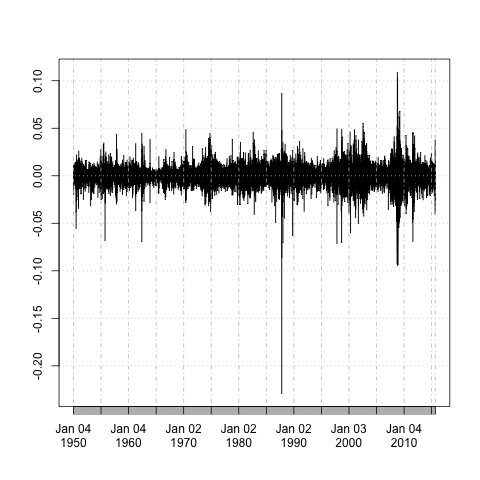

In [23]:
library(quantmod)

options("getSymbols.warning4.0"=FALSE)

getSymbols("^GSPC",from="1927-01-01") #Creates the time series object GSPC

ret.spx <- log(Cl(GSPC)/lag(Cl(GSPC)))
ret.spx <- ret.spx[!is.na(ret.spx)]  # Remove missing values
ret.spx <- ret.spx-mean(ret.spx)

plot(ret.spx,main=NA,type="l")

Figure1: Large moves follow large moves and small moves follow small moves:  "volatility clustering".

### Frequency distribution of log returns

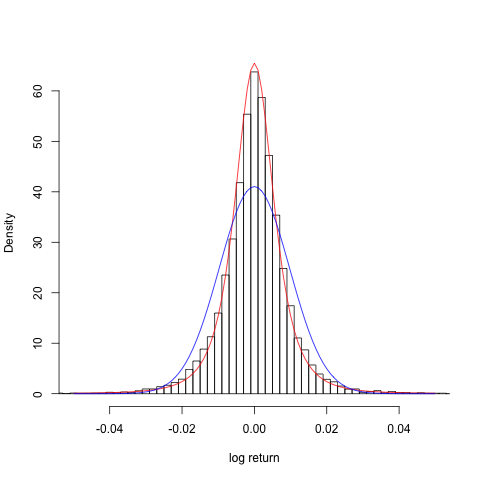

In [24]:
breaks <- seq(-.235,.115,.002)
spx.hist <- hist(ret.spx,breaks=breaks,plot=F) 
plot(spx.hist,xlim=c(-.05,.05),freq=F,main=NA,xlab="log return") 
sig <- sd(as.numeric(ret.spx))
curve(dt(x*sqrt(3)/sig,df=3)*sqrt(3)/sig,from=-.05,to=.05,col="red", add=T)
curve(dnorm(x,mean=0,sd=sig),from=-.05,to=.05,col="blue", add=T)

Figure 2: Frequency distribution of SPX daily log returns (since 1950) compared with the normal distribution (blue) and Student-t with 3 degrees of freedom (red).

- Note that the x-axis has been truncated; the $-22.9\%$ return on 10/19/1987 is not directly visible.

### A toy regime-switching model

Suppose that realized volatility over a one-year period can be either $10\%$ or $30\%$, each with probability $1/2$ (depending on an initial coin toss say).

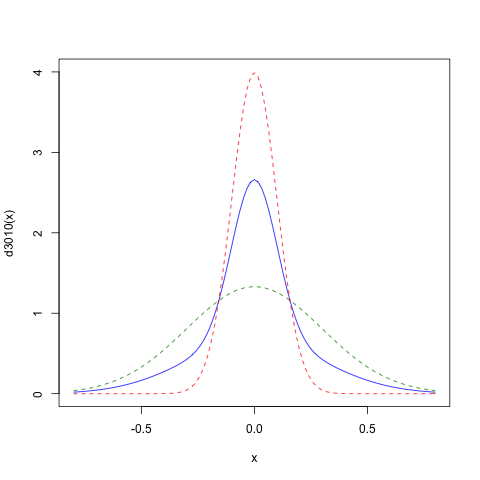

In [13]:
d3010 <- function(x){(dnorm(x,sd=.1)+dnorm(x,sd=.3))/2}
curve(d3010(x),from=-.8,to=.8,col="blue",ylim=c(0,4))
curve(dnorm(x,sd=.1),from=-.8,to=.8,col="red",lty=2,add=T)
curve(dnorm(x,sd=.3),from=-.8,to=.8,col="green4",lty=2,add=T)

Figure 3: The two-regime density in blue; $10\%$ and $30\%$ volatility distributions in green and red respectively.

- In some sense, the peak of the distribution is driven by the low volatility regime and the tails by the high volatility regime.

- Fat tails and the high central peak are characteristics of mixtures of distributions with different variances.

### Add more regimes

Consider the following 20-regime model:

In [19]:
d.20regimes <- function(x){
    res <- 0
    for (i in 1:20){ res <- res + dnorm(x,sd=i/20)}
    return(res/20)
}

The resulting density is:

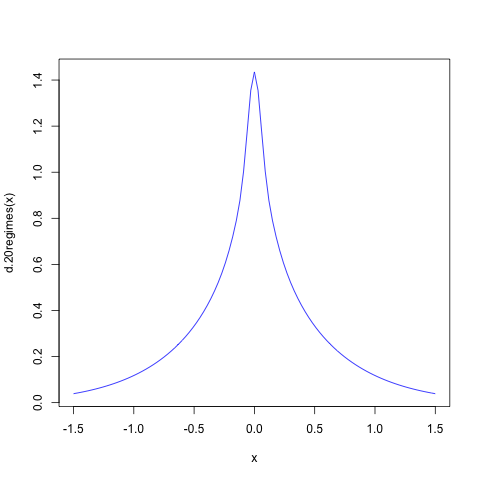

In [21]:
curve(d.20regimes(x),from=-1.5,to=1.5,col="blue")

Figure 4: The 20-regime density in blue.  Note the high central peak and fat tails.

### Interpretation

-   <span>Fat tails and the high central peak are characteristics of
    mixtures of distributions with different variances.</span>

    -   <span>This motivates us to model variance as a random
        variable</span>.

-   <span>The volatility clustering feature implies that volatility (or
    variance) is auto-correlated. </span>

    -   <span>In SV models, this is a consequence of the mean reversion
        of volatility.</span>

-   <span>Note that simple jump-diffusion models do not have this
    volatility clustering property. After a jump, the stock price
    volatility does not change.</span>

### Economic argument for mean reversion

-   <span> Consider the distribution of the volatility of IBM in one
    hundred years time say. </span>

-   <span>If volatility were not mean-reverting (* i.e.* if the
    distribution of volatility were not stable), the probability of the
    volatility of IBM being between 1% and 100% would be rather low.
    </span>

-   <span>Since we believe that it is overwhelmingly likely that the
    volatility of IBM would in fact lie in that range, we deduce that
    volatility must be mean-reverting.</span>

### The SV process

We suppose that the stock price $S$ and its variance $v$ satisfy the
following SDEs:

<a name="eq1:genstockprocess"></a>(1)
$$
dS_t = \mu_t \,S_t \,dt + \sqrt {v_t}\, S_t\, dZ_t
$$

<a name="eq2:genvarprocess"></a>(2)
$$
dv_t =   \alpha (S_t,v_t,t) \,dt + \eta \,\beta(S_t,v_t,t)\,\sqrt{v_t}\, dW_t
$$

with 

$$\left\langle {dZ_t \,{dW_t} } \right\rangle = \rho \,{ dt}$$

where $\mu_t$ is the (deterministic) instantaneous drift of stock price
returns, $\eta$ is the volatility of volatility and $\rho$ is the
correlation between random stock price returns and changes in $v_t$.
${dZ}$ and ${dW}$ are Wiener processes.

### The stock price process

-   <span>The stochastic process [(1)](#eq1:genstockprocess) followed by the
    stock price is equivalent to the Black-Scholes (BS) process.</span>

    -   <span>This ensures that the standard time-dependent volatility
        version of the Black-Scholes formula may be retrieved in the
        limit $ \eta \to 0$.</span>

-   <span>In practical applications, this is desirable for a stochastic
    volatility option pricing model as practitioners’ intuition for the
    behavior of option prices is invariably expressed within the
    framework of the Black-Scholes formula.</span>

### The variance process

-   <span>The stochastic process [(2)](#eq2:genvarprocess) followed by the
    variance is very general. </span>

-   <span>We don’t assume anything about the functional forms of
    $\alpha(\cdot)$ and $\beta(\cdot)$.</span>

-   <span> In particular, we don’t assume a square-root process for
    variance. </span>

### The hedge portfolio

Following closely the argument of [Wilmott]<sup id="cite_ref-Wilmott" class="reference"><a href="#cite_note-Wilmott"><span>[</span>9<span>]</span></a></sup>

-   <span>In the Black-Scholes case, there is only one source of
    randomness – the stock price, which can be hedged with stock.</span>

-   <span>In the one-factor SV case, random changes in volatility also
    need to be hedged in order to form a riskless portfolio.</span>

-   <span>We construct a portfolio $\Pi$ containing the option being
    priced whose value we denote by $V(S,v,t)$, a quantity $-\Delta$ of
    the stock and a quantity $-\Delta_1$ of another asset whose value
    $V_1$ depends on volatility.</span>

    -   <span>In an $n$-factor stochastic volatility model, we would
        have $n$ different such assets in the hedge portfolio.</span>

-   <span>The value of the hedge portfolio is given by
    $$\Pi  = V - \Delta \,\,S - \Delta _1 \,\,V_1$$ </span>

### Evolution of the hedge portfolio

An application of Itô’s Lemma gives the change in the value of this
portfolio over some small time interval $ \delta t$:

\begin{eqnarray*}
\delta\Pi &=& \left\{ {\frac{\partial V}{\partial t} +
\frac{1}{2}\,v\,S^2\,\,\frac{\partial ^2 V}{\partial S^2 } +
\rho\,\eta\,v\,\beta\,S\,\frac{\partial ^2 V}{\partial v\,\partial
S} + \frac{1}{2}\eta ^2 v\beta ^2 \frac{\partial ^2 V}{\partial v^2
}} \right\}\,\delta t \nonumber\\
&& - \Delta _1\, \left\{ \frac{\partial V_1 }{\partial t} +
\frac{1}{2}\,v\,S^2\,\frac{\partial ^2 V_1}{\partial S^2}\right.\nonumber\\
&&\hspace{6em}\left. +
\rho\,\eta \,v \,\beta \,S\,\frac{\partial ^2 V_1 }{\partial v\,\partial S}
+ \frac{1}{2}\,\eta^2\, v\,\beta^2 \,\frac{\partial ^2 V_1}{\partial v^2 }\right\}\,\delta t \nonumber\\
&& + \left\{\frac{\partial V}{\partial S}
- \Delta _1\, \frac{\partial V_1}{\partial S} - \Delta  \right\}\,\delta S \nonumber\\
&&+ \left\{{\frac{\partial V}{\partial v} - \Delta _1\, \frac{\partial V_1}{\partial v}} \right\}\,\delta v
\end{eqnarray*}


### Risk neutralization

To make the hedge portfolio instantaneously risk-free, we must choose

<a name="eq3:stockDelta"></a>(3)
$$\frac{{\partial V}}{{\partial S}} - \Delta _1 \frac{{\partial V_1
}}{{\partial S}} - \Delta  = 0 $$

to eliminate the $ \delta S$ term, and

<a name="eq4:vDelta"></a>(4)
$$\frac{{\partial V}}{{\partial v }} - \Delta _1 \frac{{\partial V_1}}{{\partial v }} = 0$$

to eliminate the $\delta v $ term.

### The rate of return on a risk neutral portfolio

This leaves us with

\begin{eqnarray*}
\delta \Pi &=& \left\{ \frac{\partial V}{\partial t} +
\frac{1}{2}\, v\,S^2 \,\frac{\partial ^2 V}{\partial S^2 } +
\rho\, \eta \, v \, \beta \,S\,\frac{\partial ^2 V}{\partial v\partial S} 
+ \frac{1}{2}\,\eta^2 \,v \,\beta^2\,\frac{\partial ^2 V}{\partial v^2 } \right\}\delta t \nonumber\\ 
&& - \Delta _1\, \left\{ \frac{\partial V_1 }{\partial t} +
\frac{1}{2}\,v\,S^2\,\frac{\partial ^2 V_1}{\partial S^2}\right.\nonumber\\
&&\hspace{6em}\left. +  \rho\,\eta \,v \,\beta \,S\,\frac{\partial ^2 V_1 }{\partial v\,\partial S}
+ \frac{1}{2}\,\eta^2\, v\,\beta^2 \,\frac{\partial ^2 V_1}{\partial v^2 }\right\}\,\delta t\nonumber\\ 
&=& r \, \Pi \,
\delta t \nonumber\\ &=& r (V-\Delta S -\Delta_1 V_1) \, \delta  t
\end{eqnarray*}


where we have used the fact that the return on a risk-free portfolio
must equal the risk-free rate $r$.

Collecting all $V$ terms on the left-hand side and all $V_1$ terms on
the right-hand side, and re-expressing $\Delta$ and $\Delta_1$ using
[(3)](#eq3:stockDelta) and [(4)](#eq4:vDelta) we get

\begin{eqnarray*}
&&\frac{{\frac{{\partial V}}{{\partial t}}{  } + \frac{1}{2}v\,S^2 {
}\frac{{\partial ^2 V}}{{\partial S^2 }} + \rho \eta \,v\, \beta \,S
\frac{{\partial ^2 V}}{{\partial v\partial S}} + \frac{1}{2}\eta ^2
v\beta ^2 \frac{{\partial ^2 V}}{{\partial v^2 }}+r S
\frac{{\partial V}}{{\partial S}}-r V}}{{\frac{{\partial
V}}{{\partial v }}}} \nonumber\\ &=& \frac{{\frac{{\partial V_1
}}{{\partial t}}{  } + \frac{1}{2}v\,S^2{ }\frac{{\partial ^2 V_1
}}{{\partial S^2 }} + \rho \eta \,v \beta \,S\frac{{\partial ^2 V_1
}}{{\partial v\partial S}} + \frac{1}{2}\eta ^2 v\beta ^2
\frac{{\partial ^2 V_1 }}{{\partial v^2 }}+r S \frac{{\partial
V_1}}{{\partial S}}-r V_1}}{{\frac{{\partial V_1 }}{{\partial v
}}}}{  }
\end{eqnarray*}


### The valuation equation

The left-hand side refers only to $V$ and the right-hand side refers
only to $V_1$. The only way that this can be is for both sides to be
equal to some function $f$ of the *independent* variables $S$, $v$ and
$t$. We deduce that

<a name="eq5:genval"></a>(5)
$$
\begin{eqnarray}
&&\frac{\partial V}{\partial t}
+ \frac{1}{2}\,v\,S^2\,\frac{\partial^2 V}{\partial S^2 }
+ \rho\,\eta\,v\,\beta\,S\frac{\partial^2 V}{\partial v\,\partial S}
+ \frac{1}{2}\,\eta^2\,v\,\beta^2\,\frac{\partial ^2 V}{\partial v^2}
+r\,S\,\frac{\partial V}{\partial S}-r\,V\nonumber\\
&=&- \left( \alpha  - \phi\,\eta\,\beta\,\sqrt{v}  \right)\,\frac{\partial V}{\partial v}
\end{eqnarray}
$$

where, without loss of generality, we have written the arbitrary
function $f$ of $S$, $v$ and $t$ as $\left(\alpha  - \phi
\,\eta\,\beta\,\sqrt{v}\right) $ where $\alpha$ and $\beta$ are the
drift and volatility functions from the SDE [(2)](#eq2:genvarprocess) for
instantaneous variance.

### The market price of volatility risk

$\phi (S,v,t)$ is called the market price of volatility risk . To see
why, consider the portfolio $\Pi_1$ consisting of a delta-hedged (but
not vega-hedged) option $V$. Then

$$\Pi_1  = V - \frac{\partial V}{\partial S}\,S$$ and again applying
Itô’s Lemma,

\begin{eqnarray*}
\delta\Pi_1 &=& \left\{\frac{\partial V}{\partial t} +
\frac{1}{2}\,v\,S^2\,\frac{\partial ^2 V}{\partial S^2 } +
\rho\,\eta\,v\,\beta\,S\,\frac{\partial ^2 V}{\partial v\,\partial
S} + \frac{1}{2}\eta^2\,v\,\beta^2\,\frac{\partial^2 V}{\partial v^2} \right\}\,\delta t \nonumber\\
&& + \left\{\frac{\partial V}{\partial S} - \Delta \right\}\,\delta S +
\left\{\frac{\partial V}{\partial v}\right\}\,\delta v
\end{eqnarray*}

Because the option is delta-hedged, the coefficient of $\delta S$ is
zero and we are left with

\begin{eqnarray*}
&&\delta\Pi_1-r\,\Pi_1\,\delta t \\
&=& \left\{ \frac{\partial V}{\partial t} +
\frac{1}{2}\,v\,S^2\,\,\frac{\partial ^2 V}{\partial S^2 } +
\rho\,\eta\,v\,\beta\,S\,\frac{\partial ^2 V}{\partial v\,\partial
S} \right.\\ &&\hspace{3em}+\left. \frac{1}{2}\eta ^2\, v\,\beta ^2\, \frac{\partial ^2
V}{\partial v^2} -r\,S\,\frac{\partial V}{\partial S}-r\,V \right\}\,\delta t+ \frac{\partial V}{\partial v}\,\delta v\\
&=&\eta\,\beta\,\sqrt{v}\,\frac{\partial V}{\partial
v}\,\left\{\phi(S,v,t)\,\delta t+\delta W\right\}
\end{eqnarray*}

where we have used both the valuation equation [(5)](#eq5:genval) and the SDE
[(2)](#eq2:genvarprocess) for $v$.

-   <span>The extra return per unit of volatility risk $\delta Z_2$ is
    given by $\phi(S,v,t)\,\delta t$</span>

-   <span>In analogy with the Capital Asset Pricing Model, $\phi$ is
    known as the *market price of volatility risk*.</span>
    

### Transforming to the risk-neutral measure

Now, defining the *risk-neutral drift* as

$$\alpha'=\alpha-\eta\,\beta\,\sqrt{v}\,\phi$$

we see that as far as
pricing of options is concerned, we could have started with the
risk-neutral SDE for $v$

$$dv=\alpha'\,dt+\eta\,\beta\,\sqrt{v}\,dW$$

and got identical results with no explicit price of risk term (because
we are in the risk-neutral world).



### In slightly different language

Under the physical measure $\mathbb{P}$,

$$dv=\alpha\,dt+\eta\,\beta\,\sqrt{v}\,dW^{\mathbb{P}}.$$

Under the pricing measure $\mathbb{Q}$,

$$dv=\alpha\,dt+\eta\,\beta\,\sqrt{v}\,dW^{\mathbb{Q}}$$

where $dW^{\mathbb{Q}} = dW^{\mathbb{P}} - \phi(S,v,t)\,d t$.

- $\phi$ is the drift in the Girsanov transformation between the physical measure $\mathbb{P}$ and the pricing measure $\mathbb{Q}$.

### Risk neutrality and market completeness

-   <span>In practical applications of SV models, we always assume that
    the SDEs for $S$ and $v$ are in risk-neutral terms because we are
    invariably interested in fitting models to option prices.</span>

    -   <span>We effectively impute the risk-neutral measure by fitting
        the parameters of the process we are imposing.</span>

    -   <span>We need $n$ options in the hedge portfolio for an
        $n$-factor SV model.</span>

-   <span>Only if we were interested in the connection between the
    pricing of options and the behavior of the time series of historical
    returns of the underlying, would we need to understand the
    connection between the statistical measure under which the drift of
    the variance process $v$ is $\alpha$ and the risk-neutral process
    under which the drift of the variance process is $\alpha'$.</span>

-   <span>Academics often say that SV models are not complete. This is
    true only if there are no traded derivative securities.</span>

### Solving the valuation equation

Recall the valuation equation for a one-factor SV model (with $r=0$ for
simplicity):

$$\frac{\partial V}{\partial t}
+ \frac{1}{2}\,v\,S^2\,\frac{\partial^2 V}{\partial S^2 }
+ \rho\,\eta\,v\,\beta\,S\frac{\partial^2 V}{\partial v\,\partial S}
+ \frac{1}{2}\,\eta^2\,v\,\beta^2\,\frac{\partial ^2 V}{\partial v^2}
+\alpha\,\frac{\partial V}{\partial v}=0$$

How easy this is to solve
depends on $\alpha(\cdot)$, $\beta(\cdot)$ and the boundary conditions.

-   <span>Fast solutions for European options are needed for calibration
    to market option prices.</span>

-   <span>The boundary condition for a European call option is
    
    $$V(S,K,t,T)|_{t=T}=\left(S-K\right)^+.$$ </span>

-   <span>For general payoffs (*i.e.* boundary conditions), we solve the
    valuation equation using numerical PDE or Monte Carlo
    techniques.</span>

-   <span>This is too slow for efficient calibration.</span>

-   <span>Models for which fast exact or approximate European option
    solutions exist are consequently the most popular.</span>

### Examples of stochastic volatility models

### The Heston model

In the Heston model,

$$\alpha = -\lambda\,(v-\bar v);\, \beta=1$$

So
that (again with $r=0$)

\begin{eqnarray*}
dS_t & =& \sqrt {v_t}\, S_t\, dZ_1\\
dv_t  &=&   -\lambda\,(v-\bar v) \,dt + \eta \,\sqrt{v_t} dZ_2 
\end{eqnarray*}

with

$$\left\langle {dZ_1 \,{dZ_2} } \right\rangle = \rho \,{ dt}$$

The
corresponding valuation equation with European boundary conditions may
be solved using Fourier techniques leading to a quasi-closed form
solution – the famous Heston formula.

### The SABR model

The SABR model is usually written in the form

\begin{eqnarray*}
dS_t =& \sigma\, S_t^\beta\, dZ_1\\
d\sigma_t  =&   \alpha \,\sigma \,dZ_2 \end{eqnarray*}

with $$\left\langle {dZ_1 \,{dZ_2} } \right\rangle = \rho \,{ dt}$$
Hence the name \`\`stochastic alpha beta rho model".

-   <span>Note that this formulation is in general inconsistent with our
    original formulation [(1)](#eq1:genstockprocess) because the stock price
    is conditionally lognormal only if $\beta=1$. We get the CEV model
    in the limit $\alpha \to 0$.</span>

-   <span>There is an accurate asymptotic formula for BS implied
    volatility (the SABR formula) in terms of the parameters of the
    model permitting easy calibration to the volatility smile.</span>

### Extension to $n$ factors

-   <span>In a one factor SV model, given the stock price $S$ and the
    market price of *only one option*, in principle we know the prices
    of all options.</span>

    -   <span>This is an extreme assumption.</span>

-   It may be desirable (essential if jointly calibrating to the prices
    of volatility derivatives) to include more factors. For example, in
    the Double Mean Reverting (DMR) model [Bayer, Gatheral and Karlsmark]<sup id="cite_ref-2BGK" class="reference"><a href="#cite_note-2BGK"><span>[</span>2<span>]</span></a></sup>:

    \begin{eqnarray*}
    dS&=&\sqrt{v_1}\,S\,dZ_1\\
    dv_1&=&-\kappa_1\,(v_1-v_2)\,dt+\eta_1\,{v_1}^{\alpha_1}\,dZ_2\\
    dv_2&=&-\kappa_2\,(v_2-\bar v)\,dt+\eta_2\,{v_2}^{\alpha_2}\,dZ_3
    \end{eqnarray*}

    with
    
    $$\langle dZ_i\,dZ_j \rangle=\rho_{ij}\,dt$$
    

    -   In the DMR model, we know all option prices given the stock price and the prices of two options.

## Local Volatility

### Local volatility: Historical development

- <span>Stochastic volatility models are hard to handle</span>

    - <span>difficult to compute with and hard (impossible) to
calibrate.</span>

- <span>Practitioners need a simple way of pricing exotic options
consistently with the volatility skew.</span>

### Risk-neutral density from prices

The marginal risk-neutral density may be recovered by twice
differentiating European call prices wrt strike: $
p(K)=\frac{\partial^2C}{\partial K^2}.
$




#### Proof.
$$C(K)={\mathbb{E} }[(S_T-K)^+]$$ so
$$-\frac{\partial C}{\partial K}={\mathbb{E} }[\theta(S_T-K)]=\Pr(S_T>K)$$
and
$$\frac{\partial^2C}{\partial K^2}={\mathbb{E} }[\delta(S_T-K)]=p(K).$$

### The trader version: The butterfly

- <span>Consider the payoff of the following option combination:</span>

    - <span>Long a call struck at $K+\Delta K$,</span>

    - <span>short 2 calls struck at $K$,</span>

    - <span>long a call struck at $K-\Delta K$.</span>

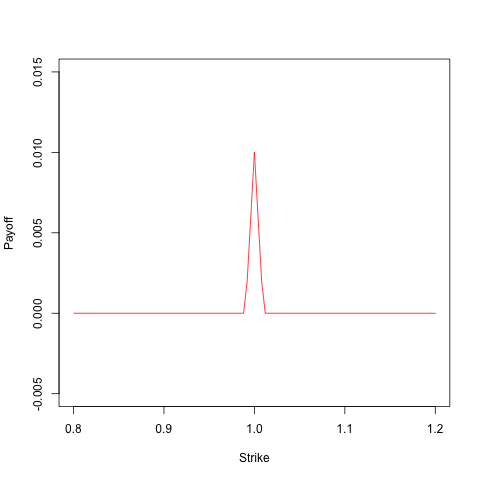

In [25]:
callPayoff <- function(x,K){pmax(x-K,0)} 
putPayoff <- function(x,K){pmax(K-x,0)} 

butterfly <- function(x){callPayoff(x,.99)-2*callPayoff(x,1)+callPayoff(x,1.01)}

curve(butterfly(x),from=.8,to=1.2,ylim=c(-0.005,0.015),col="red",xlab="Strike", ylab="Payoff")

Figure 5: Payoff of a butterfly with strikes $\{0.99,1.00,1.01\}$.

### The key idea

- <span>For as long as options have been traded (probably), it has been
understood that the risk-neutral density could be derived from the
market prices of European options. </span>

    - <span>This is the famous Breeden-Litzenberger result.</span>

- <span>The breakthrough came when [Dupire]<sup id="cite_ref-5Dupire" class="reference"><a href="#cite_note-5Dupire"><span>[</span>5<span>]</span></a></sup> and [Derman and Kani]<sup id="cite_ref-3DermanKani" class="reference"><a href="#cite_note-3DermanKani"><span>[</span>3<span>]</span></a></sup> noted that
under risk-neutrality, there was a unique diffusion process consistent
with these distributions.</span>

    - <span>The corresponding unique state-dependent diffusion coefficient
$\sigma_L(S,t)$ consistent with current European option prices is known
as the <span>*local volatility function*</span>.</span>

### Local volatility: Philosophy

- <span>It is unlikely that Dupire, Derman and Kani (DDK) ever thought of
local volatility as representing a model of how volatilities actually
evolve.</span>

    - <span>[Dumas, Fleming and Whaley]<sup id="cite_ref-4DumasFlemingWhaley" class="reference"><a href="#cite_note-4DumasFlemingWhaley"><span>[</span>4<span>]</span></a></sup> confirmed empirically that the dynamics of the
implied volatility surface were not consistent with the assumption of
constant local volatilities. </span>

- <span> They likely thought of local volatilities as representing some
kind of average over all possible instantaneous volatilities in a
stochastic volatility world (an “effective theory”).</span>

    - <span>We will prove a precise version of this idea later in this
lecture, formalizing the DDK intuition.</span>

- <span>Local volatility is the simplest extension of Black-Scholes that
allows practitioners to price exotic options consistently with the known
prices of vanilla options.</span>

### A Brief Review of Dupire’s Work

- <span> Given $T$-expiration European call prices
$\left\{ {C\left( {S_0 ,K,T} \right)}\right\}$, the risk neutral density
function $\varphi$ of the final spot $S_T$ is given by

$$\varphi \left( {K,T;S_0 } \right) = \frac{\partial ^2 C}{\partial
K^2}.$$ </span>

- <span> Dupire showed that there is a unique risk-neutral diffusion
process which generates a given marginal distribution of final spot
prices $S_T$ for each time $T$, conditional on some starting spot price
$S_0$.</span>

    - <span>It has become the fashion in the literature to credit Gyöngy with
this result.</span>

- <span> Equivalently, given the set of all European option prices, we may
determine the functional form of the diffusion parameter (local
volatility) of the unique risk neutral diffusion process which generates
these prices.</span>

### The Fokker-Planck equation

Recall from Lecture 1 that if

$$
dX_t=\mu(X_t,t)\,dt+\sigma(X_t,t)\,dW_t,
$$

the density $p$ evolves as

$$
\frac{d p(x,t)}{dt}=-\frac{\partial}{\partial x}\left(\mu(x,t)\,p(x,t)\right)+\frac{1}{2}\,\frac{\partial^2}{\partial x^2}\,\left(\sigma^2(x,t)\,p(x,t)\right).
$$

Thus, if the stock price evolves according to the local volatility SDE

$$\frac{dS_t}{S_t} = \mu_t\,dt + \sigma \left( {S_t,t} \right)\,dW_t,$$

the density evolves as

$$ \frac{\partial p }{\partial T}=\frac{1}{2}\frac{\partial ^2 }{\partial S_T ^2 }\left( \sigma ^2 S_T
^2 \,p\right) - \frac{\partial }{\partial S_T }\left(
\mu_T\, S_T\, p  \right) .$$


### Derivation of the Dupire Equation

Suppose the stock price diffuses with risk-neutral drift
$ \mu_t\,(=r_t-D_t)$ and local volatility $
\sigma \left( {S,t} \right)$ according to the equation:

$$\frac{dS_t}{S_t} = \mu_t\,dt + \sigma \left( {S_t,t} \right)\,dZ_t$$ 

The
undiscounted risk-neutral value $ C\left( {S_t ,K,T} \right)$ of a
European option with strike $K$ and time to expiration $T$ is given by

<a name="eq6:callintegral"></a>(6)
\begin{equation}{
C\left( {S_t ,K,T} \right) = \int_K^\infty \, dS_T \,p \left(
{S_T ,T } \right)\,\left( S_T  - K \right)}
\end{equation}



Then, differentiating [(6)](#eq6:callintegral) with respect to $T$ and applying the Fokker-Planck equation gives

\begin{eqnarray*}
\frac{\partial C}{\partial T} &=& \int_K^\infty \,dS_T \,\left\{
{\frac{\partial}{\partial T}\,p \,
\left( {S_T,T } \right)\,} \right\}\left( S_T  - K \right) \nonumber\\
&=& \int_K^\infty \, dS_T \,\left\{ \frac{1}{2}\,\frac{\partial ^2
}{\partial S_T ^2 }\,\left( {\sigma ^2 S_T ^2\, p } \right) -
\frac{\partial }{{\partial S_T }} \left( \mu_T \,S_T\,p\right)\,
\right\}\,\left( {S_T  - K} \right)
\end{eqnarray*}


Integrating by parts gives:

<a name="eq7:Dupire"></a>(7)
\begin{eqnarray}
\frac{\partial C}{\partial T} &=& \frac{\sigma ^2\, K^2
}{2}\,p  + \int_K^\infty \, dS_T \,\mu_T\, S_T\, p \nonumber\\
&=& \frac{\sigma ^2 \,K^2 }{2}\,\frac{\partial ^2 C}{\partial K^2} +
\mu_T\,\left( C - K\,\frac{\partial C}{\partial K}\right)
\end{eqnarray}

which is the Dupire equation when the underlying stock has risk-neutral
drift $\mu_t$.

### Under the forward measure

As of time $t$, the time $T$ forward price of the stock  is given by
$$F_T = S_t \,\exp \left\{ \int_t^T \,\mu_s\,ds \right\}.$$

It is then straightforward to verify using Itô's Lemma that

$$
dF_t = F_t\,\sigma(S_t,t)\,dt,
$$

which with some abuse of notation, we may rewrite as 

$$
dF_t = F_t\,\sigma(F_t,t)\,dt.
$$

In that case (or equivalenty if were to set rates and dividends to zero), we would get the 
get the same expression as [(7)](#eq7:Dupire) without the drift term. That is

$$\frac{{\partial C}}{{\partial T}} = \frac{{1 }}{2}\,\sigma
^2\,K^2\,\frac{{\partial ^2 C}}{{\partial K^2 }}$$

where $C$ now
represents $C\left( {F_T ,K,T} \right)$.

Inverting this gives the Dupire equation in its simplest form:

<br>

<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
The Dupire equation</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>
<a name="eq8:localvoldef"></a>(8)
$$
\begin{equation}
\sigma ^2(K,T,S_0)\,=\,\frac { \frac{{\partial C}}{{\partial T}}}
{ \frac{{1 }}{2}\,\,K^2\,\frac{{\partial ^2 C}}{{\partial K^2 }}}
\end{equation}
$$

<br>

</div>

</blockquote>

<br>

<font color="black">
- <span> The right hand side of equation [(8)](#eq8:localvoldef) can in
principle be computed from known European option prices. </span>

    - <span>Given a complete set of European option prices for all strikes and
expirations, local volatilities are given uniquely by equation
[(8)](#eq8:localvoldef).</span>

    - <span>In words, “local variance is given by the ratio of a calendar
spread to a butterfly”.</span>

- <span>We can view equation [(8)](#eq8:localvoldef) as a *definition* of the
local volatility function regardless of what kind of process (stochastic
volatility for example) actually governs the evolution of
volatility.</span>

### Local volatility in terms of implied volatility

Market prices of options are quoted in terms of Black-Scholes implied
volatility $
\sigma _{BS} \left( {K,T;S_0 } \right)$. In other words, we may write

$$C\left( {S_0 ,K,T} \right) = C_{BS} \left( {S_0 ,K,\sigma _{BS}
\left( {S_0 ,K,T} \right),T} \right)$$

It will be more convenient for us
to work in terms of two dimensionless variables: the Black-Scholes
<span>*implied total variance*</span> $w$ defined by

$${\mathop{ w}} \left( {S_0 ,K,T} \right) := \sigma _{BS} ^2 \left(
{S_0 ,K,T} \right)\,T$$ 

and the log-strike $k$ defined by

$$k = \log \left( \frac{K}{F_T } \right)$$

where
$ F_T  = S_0 \,\exp \left\{\int_0^T\,\mu_t\,dt \right \} $ is the
forward price.

### Black-Scholes formula in terms of log-strike and total variance

In terms of these variables, the Black-Scholes formula for the
undiscounted call price becomes

<a name="eq9:BS"></a>(9)
\begin{eqnarray*}
C_{BS} &=& 
F_T\, \left\{N\left( d_1  \right) - e^k\, N\left( d_2  \right) \right\}\\
&=& F_T\, \left\{ N \left( -\frac{k}{\sqrt{w}} +\frac{ \sqrt{w}}{2} \right)
 - e^k \,  N \left( -\frac{k}{ \sqrt{w} } -\frac{ \sqrt{w} }{2} \right)
 \right\}
\end{eqnarray*}


and the Dupire equation [(7)](#eq7:Dupire) becomes

<a name="eq10:dupirex"></a>(10)
$$
\frac{\partial C}{\partial T} = 
\frac{v_L }{2}\,\left\{
\frac{\partial ^2 C}{\partial k^2 } - \frac{\partial C}{\partial k} \right\}
 + \mu_T\, \,C
$$

with $v_L  = \sigma ^2 \left( S_0 ,K,T \right)$ representing the local
variance.

Now, by taking derivatives of the Black-Scholes formula [(9)](#eq9:BS), we
obtain

<a name="eq11:BSderivatives"></a>(11)
\begin{eqnarray}
\frac{\partial ^2 C_{BS} }{\partial w^2 } &=&
\left(  - \frac{1}{8} - \frac{1}{2\,w} + \frac{k^2}{2\,w^2} \right)\,
\frac{\partial C_{BS} }{\partial w} \nonumber\\
\frac{\partial ^2 C_{BS}}{\partial k \partial w}
&=& \,\left(  \frac{1}{2} - \frac{k}{w}\right)\,
\frac{\partial C_{BS}}{\partial w}\nonumber\\
\frac{\partial ^2 C_{BS} }{\partial k^2 } -\frac{\partial C_{BS} }{\partial k} 
&=& 2\,\frac{\partial C_{BS} }{\partial w}
\end{eqnarray}

### Dupire equation in terms of implied variance

We may transform equation [(10)](#eq10:dupirex) into an equation in terms of
implied variance by making the substitutions

\begin{eqnarray*}
\frac{\partial C}{\partial k} &=& 
\frac{\partial C_{BS}}{\partial k} + \frac{\partial C_{BS}}{\partial w}\,\frac{\partial w}{\partial k} \nonumber\\
\frac{\partial ^2 C}{\partial k^2 } &=& 
\frac{\partial^2 C_{BS} }{\partial k^2 } + 2\,\frac{\partial ^2 C_{BS} }{\partial k \partial w}\,
\frac{\partial w}{\partial k} + \frac{\partial^2 C_{BS} }{\partial w^2}\,
\left( \frac{\partial w}{\partial k} \right)^2
+ \frac{\partial C_{BS} }{\partial w}\,\frac{\partial ^2 w}{\partial k^2 } \nonumber\\
\frac{\partial C}{\partial T} &=&
 \frac{\partial C_{BS}}{\partial T} + \frac{\partial C_{BS} }{\partial w}\,\frac{\partial w}{\partial T}
 = \frac{\partial C_{BS} }{\partial w}\,\frac{\partial w}{\partial T} + \mu_T\,C_{BS}
\end{eqnarray*}

where the last equality follows from the fact that the only explicit
dependence of the option price on $T$ in equation [(9)](#eq9:BS) is through
the forward price
$ F_T  = S_0 \exp \left\{ \int_0^T \,\mu_t\,dt \right\}\,$.

Canceling $\mu_T\,C $ terms on each side and using [(11)](#eq11:BSderivatives),
equation [(7)](#eq7:Dupire) now becomes

\begin{eqnarray*}
&&\frac{\partial C_{BS} }{\partial w}\,\frac{\partial w}{\partial T}\\
 &=& \frac{v_L}{2}\,\left\{
 -\frac{\partial C_{BS} }{\partial k} +
\frac{\partial ^2 C_{BS} }{\partial k^2 } - \frac{\partial
C_{BS} }{\partial w}\,\frac{\partial w}{\partial k} + 2\,\frac{\partial ^2 C_{BS} }{\partial k\, \partial w}\,\frac{\partial w}{\partial k} +\right.\nonumber\\
&\,& \left.
 \frac{\partial ^2 C_{BS}}{\partial w^2 }\,\left( \frac{\partial w}{\partial k} \right)^2  
 + \frac{\partial C_{BS}}{\partial w}\,\frac{\partial^2 w}{\partial k^2 } \right\}\nonumber\\
&=& \frac{v_L }{2}\,\frac{\partial C_{BS} }{\partial w}\,\left\{
2 - \frac{\partial w}{\partial k} +2\,\left(   \frac{1}{2} - \frac{k}{w}\right)\,
\frac{\partial w}{\partial k} \right.\nonumber\\
&\,& \left.
 + \left(  - \frac{1}{8} -\frac{1}{2\,w} + \frac{k^2 }{2\,w^2}\right)\,
 \left( \frac{\partial w}{\partial k}\right)^2  
 + \frac{\partial ^2 w}{\partial k^2 }\right\}
\end{eqnarray*}

### Local variance in terms of implied variance

Then, taking out a factor of $ \frac{\partial C_{BS}}{\partial w}$ and
simplifying, we get

$$\frac{\partial w}{\partial T} = v_L\,
 \left\{ 1 -\frac{k}{w}\,\frac{\partial w}{\partial k} 
 + \frac{1}{4}\left(  - \frac{1}{4} - \frac{1}{w}+ \frac{k^2 }{w^2} \right)\,
\left( \frac{\partial w}{\partial k} \right)^2  +
\frac{1}{2}\,\frac{\partial ^2 w}{\partial k^2}
\right\}$$

Inverting this and rearranging slightly gives our final
result:


<br>

<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
Local volatility from implied volatility</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>
<a name="eq12:localfromimplied"></a>(12)
$$
\begin{equation}
v_L(k,T) = \frac{\frac{\partial w}{\partial T}}
{\left(1 -\frac 12\frac{k}{w}\,\frac{\partial w}{\partial k}\right)^2
 - \frac14\,\left( \frac{1}{4} + \frac{1}{w} \right)\,
 \left( \frac{\partial w}{\partial k} \right)^2  +
\frac{1}{2}\,\frac{\partial^2 w}{\partial k^2 }}
\end{equation}
$$

<br>

</div>

</blockquote>

<br>

### Special Case: No Skew

If $w$ is a function of $T$ only and not of $k$ (so no skew and no
smile), then we must have

$$v_L = \frac{\partial w}{\partial T}$$

and
the local variance reduces to the forward Black-Scholes implied
variance. The solution to this is of course
$$w\left( T \right) = \int_0^T {v_L \left( t \right)\,dt}$$

### The Berestycki-Busca-Florent (BBF) formula

Following [Berestycki, Busca and Florent]<sup id="cite_ref-BBF" class="reference"><a href="#cite_note-BBF"><span>[</span>1<span>]</span></a></sup>, suppose $\sigma_{BS}(k,T)=\sigma_0(k)+\mathcal{O}(T)$. Then, to zeroth
order in $T$, formula [(12)](#eq12:localfromimplied) reads:

<a name="eq13:13"></a>(13)
\begin{equation}
\sigma(k,t)^2=v_{L}(k,t)=\frac{\sigma_0^2(k)+\mathcal{O}(t)}{\left(1-\frac{k}{2\,w}\,\partial_k w\right)^2+\mathcal{O}(t)}.
\end{equation}

Noting that
$$1-\frac{k}{2\,w}\,\partial_k w=\sqrt{w}\,\frac{\partial}{\partial k}\left(\frac{k}{\sqrt{w}}\right)= \sigma_0(k)\,\frac{\partial}{\partial k}\left(\frac{k}{\sigma_0(k)}\right),$$
we may rearrange [(13)](#eq13:13) to give (to zeroth order in $t$)
$$\frac{\partial}{\partial k}\left(\frac{k}{\sigma_0(k)}\right)=\frac{1}{\sigma(k,0).}$$


Integrating, we arrive at the solution:

<br>

<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
The BBF formula</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>
$$\frac{1}{\sigma_0(k)}=\frac{1}{k}\,\int_0^k\,\frac{dy}{\sigma(y,0)}=\int_0^1\,\frac{d\alpha}{\sigma(\alpha\,k,0)}$$

<br>

</div>

</blockquote>

<br>

### The heat-kernel most-likely-path formula

In a more recent paper, [Gatheral and Wang]<sup id="cite_ref-8GatheralWang" class="reference"><a href="#cite_note-8GatheralWang"><span>[</span>8<span>]</span></a></sup> derived the following fancier
approximation:

$$\frac{k^2}{\sigma_{BS}^2} \approx  T\,\int_0^T \,\left[ \frac{\dot x(t)}{\sigma(x(t),t)} \right]^2\, dt$$

where the <span>*variational most likely path (variational MLP)*</span>
$x(t)$ is the solution of the following variational problem:

<a name="eq14:mlp-bvp"></a>(14)
$$
\left\{
\begin{array}{l}
-\frac {d}{dt}\left[ \frac{\dot x(t)}{\sigma(x,t)} \right] + \frac{\partial_t \sigma(x,t)}{\sigma^2(x,t)} \dot x(t) = 0, \\
x(0) = 0, \quad x(T) = k.
 \end{array}\right.
$$



This formula reduces to the BBF formula when the local volatility
function $\sigma(x,t)$ is time-homogeneous and is much more accurate
otherwise.

### A simplification

For simplicity, in what follows, we will assume zero interest rates and
zero dividends.

### Local variance as a conditional expectation of instantaneous variance

Following Derman and Kani, write

$$C\left( {S_0 ,K,T} \right)\,=\,\mathbb{ E} \left [ (S_T - K)^+
\right ]$$

As before, differentiating twice with respect to $K$ gives

$${\frac{\partial ^2 C}{\partial K^2}}=\mathbb{ E}\left[ {\delta
\left( {S_T-K} \right)} \right]$$

where $\delta (\cdot)$ is the Dirac
$\delta$ function. Now, a formal application of Itô’s Lemma to the
terminal payoff of the option gives

<a name="eq15:TanakaDiff"></a>(15)
$$
d\left( {S_T-K} \right)^+=\theta \left( {S_T-K}
\right)\,dS_T+\frac{1}{2}\,v_T\,S_T^2\,\delta \left( {S_T-K}
\right)\,dT
$$

Taking conditional expectations of each side, and using the fact that
$S_T$ is a martingale, we get

$$dC\,=\,d\mathbb{ E}\left[ {\left( {S_T-K} \right)^+ }
\right]=\,\frac{1}{2}\, \mathbb{ E}\left[ {v_T \,S_T^2\,\delta
\left( {S_T-K} \right)} \right]\,dT$$

Also, denoting the density of the final density by $p(S_T,T)$, we can write 

\begin{eqnarray*}
\mathbb{ E}\left[ {\,v_TS_T^2\,\delta \left( {S_T-K} \right)}
\right]&=&\,\mathbb{ E}\left[ {v_T\left| {S_T=K} \right.}
\right]\,K^2\,\mathbb{ E}\left[ {\,\,\delta \left(
{S_T-K} \right)} \right]\nonumber\\
 &=&\mathbb{ E}\left[ {v_T\left| {S_T=K} \right.}
\right]\,K^2\,p(K,T)\nonumber\\
&=&\mathbb{ E}\left[ {v_T\left| {S_T=K} \right.}
\right]\,K^2\,{\frac{\partial ^2 C} {\partial K^2}}
\end{eqnarray*}

Putting this together, we get

<a name="eq16:conditionalExpectation"></a>(16)
$$\frac{\partial C} {\partial T}= 
{\mathbb{E} }\left[ v_T\left | S_T=K\right. \right]\,\frac{1}{2}K^2\,\frac{\partial ^2 C}
{\partial K^2}
$$

Comparing [(16)](#eq16:conditionalExpectation) with the definition
[(8)](#eq8:localvoldef) of local volatility, we get


<br>

<blockquote><div style="background-color:#add8e6; color:#FFFFFF; font-style: normal;  " ><h4>
Local variance as conditional expectation</h4>
</div>
<div style="background-color:#E8E8E8; color:#000000; font-style: normal; ">
<br>
$$ \sigma ^2(K,T,S_0)\,=\, \mathbb{ E}\left[ {v_T\left| {S_T=K}
\right.} \right] $$ 

<br>

</div>

</blockquote>

<br>

<font color="black">That is, local variance is the risk-neutral expectation of the
instantaneous variance conditional on the final stock price $S_T$ being
equal to the strike price $K$.

### Tanaka’s formula

Sometimes in the literature, we see [(15)](#eq15:TanakaDiff) written in
integral form as

\begin{eqnarray*}
&&\left( {S_T-K} \right)^+\\
&=&  \left( {S_0-K} \right)^+ +  \int_0^T \mathbf{1}_{S_t>K}\,dS_t
+\frac{1}{2}\,\int_0^T\,v_t\,S_t^2\,\delta \left( {S_t-K}
\right)\,dt\end{eqnarray*}

This is a form of Tanaka’s formula. It expresses the payoff of a
European call as the proceeds of a stop-loss start-gain hedging strategy
plus local time.

### References

<br />

<div class="reflist" style="list-style-type: decimal;">

<ol>
  
  <li id="cite_note-BBF"><span class="mw-cite-backlink"><b><a href="#cite_ref-BBF">^</a></b></span>   Henri Berestycki, Jérôme Busca and Igor Florent, Asymptotics and
calibration of local volatility models, <span>*Quantitative
Finance*</span> <span>**2**</span>, 61–69 (2002).</li>
 
 
  <li id="cite_note-2BGK"><span class="mw-cite-backlink"><b><a href="#cite_ref-2BGK">^</a></b></span>   Christian Bayer, Jim Gatheral, and Morten Karlsmark, Fast
Ninomiya-Victoir calibration of the double-mean-reverting model,
<span>*Quantitative Finance*</span> <span>**13**(11)</span>, 1813–1829 (2013).</li>

  <li id="cite_note-3DermanKani"><span class="mw-cite-backlink"><b><a href="#cite_ref-3DermanKani">^</a></b></span>   Derman, Emanuel and Iraj Kani, Riding on a smile. <span>*Risk*</span>
<span>**7**</span>(2), 32–39 (1994).</li>

  <li id="cite_note-4DumasFlemingWhaley"><span class="mw-cite-backlink"><b><a href="#cite_ref-4DumasFlemingWhaley">^</a></b></span>   Dumas, Bernard, Jeff Fleming and Robert E Whaley, Implied Volatility
Functions: Empirical Tests, <span>*Journal of Finance*</span>
<span>**53**</span>, 2059–2106 (1998).</li>

  <li id="cite_note-5Dupire"><span class="mw-cite-backlink"><b><a href="#cite_ref-5Dupire">^</a></b></span>   Dupire Bruno, <span>Pricing with a smile</span>, <span>*Risk*</span>
<span>**7**</span>(1), 18–20 (1994).</li>

  <li id="cite_note-6Gatheral"><span class="mw-cite-backlink"><b><a href="#cite_ref-6Gatheral">^</a></b></span>Jim Gatheral, <span>*The Volatility Surface: A Practitioner’s
Guide*</span>, John Wiley and Sons, Hoboken, NJ (2006).</li>

  <li id="cite_note-7Gatheral:Bachelier"><span class="mw-cite-backlink"><b><a href="#cite_ref-7Gatheral:Bachelier">^</a></b></span>Jim Gatheral, <span>*Consistent Modeling of SPX and VIX Options*</span>,
Fifth World Congress of the Bachelier Finance Society (2008).</li>

  <li id="cite_note-8GatheralWang"><span class="mw-cite-backlink"><b><a href="#cite_ref-8GatheralWang">^</a></b></span>Jim Gatheral and Tai-Ho Wang, The heat-kernel most-likely-path
approximation, <span>*International Journal of Theoretical and Applied
Finance*</span> <span>**15**</span>(1) 1250001-1–1250001-18 (2012).</li>

  <li id="cite_note-Wilmott"><span class="mw-cite-backlink"><b><a href="#cite_ref-Wilmott">^</a></b></span>Paul Wilmott, <span>*Paul Wilmott Introduces Quantitative
Finance*</span>, John Wiley and Sons, Chichester (2007).</li>

</ol>